# Import Libraries

In [2]:
import keras
import gc
import tensorflow as tf
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error, accuracy_score, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier

Using TensorFlow backend.


In [3]:
# Set random seeds
np.random.seed(0)
tf.set_random_seed(0)

# Open Data

In [4]:
# Open data, csv files should be in same folder as notebook.
notebook_dir = %pwd

items = pd.read_csv(notebook_dir + "/items.csv")
shops = pd.read_csv(notebook_dir + "/shops.csv")
train = pd.read_csv(notebook_dir + "/sales_train.csv")
test = pd.read_csv(notebook_dir + "/test.csv")
sample_submission = pd.read_csv(notebook_dir + "/sample_submission.csv")
item_category = pd.read_csv(notebook_dir + "/item_categories.csv")

# Exploratory Data Analysis
## Additional Data

In [5]:
print('Amount of items:', len(items))
items.head()

Amount of items: 22170


,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [6]:
print('Amount of shops:', len(shops))
shops.head()

Amount of shops: 60


,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [7]:
print('Amount of item categories:', len(item_category))
item_category.head()

Amount of item categories: 84


,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [8]:
sample_submission.head()

,ID,item_cnt_month
0,0,0.5
1,1,0.5
2,2,0.5
3,3,0.5
4,4,0.5


## Train

In [9]:
print('Size of train-set:', len(train))
train.head()

Size of train-set: 2935849


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [10]:
train.describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day
count,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06
mean,1.456991e+01,3.300173e+01,1.019723e+04,8.908532e+02,1.242641e+00
std,9.422988e+00,1.622697e+01,6.324297e+03,1.729800e+03,2.618834e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-2.200000e+01
25%,7.000000e+00,2.200000e+01,4.476000e+03,2.490000e+02,1.000000e+00
50%,1.400000e+01,3.100000e+01,9.343000e+03,3.990000e+02,1.000000e+00
75%,2.300000e+01,4.700000e+01,1.568400e+04,9.990000e+02,1.000000e+00
max,3.300000e+01,5.900000e+01,2.216900e+04,3.079800e+05,2.169000e+03


As we can see price and item count vary by quite a lot and are in some cases invalid (negative price)

In [11]:
# Drop duplicates so they cannot influence training
train.drop_duplicates(inplace=True)

{'whiskers': [<matplotlib.lines.Line2D at 0x7f00f8f6cdd8>,
 'caps': [<matplotlib.lines.Line2D at 0x7f00f8f804a8>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f00f8f6cc50>],
 'medians': [<matplotlib.lines.Line2D at 0x7f00f8f80b38>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f00f8f80e80>],
 'means': []}

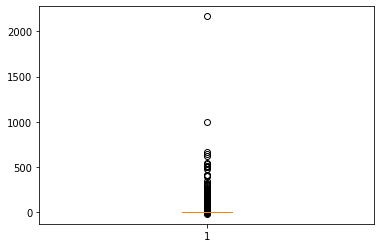

In [12]:
plt.boxplot(train['item_cnt_day'])

{'whiskers': [<matplotlib.lines.Line2D at 0x7f00f8f03b38>,
 'caps': [<matplotlib.lines.Line2D at 0x7f00f8f10278>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f00f8f039e8>],
 'medians': [<matplotlib.lines.Line2D at 0x7f00f8f10908>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f00f8f10c50>],
 'means': []}

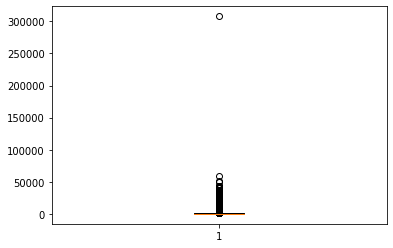

In [13]:
plt.boxplot(train['item_price'])

(array([ 7.,  0.,  4.,  6.,  8.,  4.,  1.,  2.,  1.,  1.]),
 array([  50588. ,   59853.8,   69119.6,   78385.4,   87651.2,   96917. ,
         106182.8,  115448.6,  124714.4,  133980.2,  143246. ]),
 <a list of 10 Patch objects>)

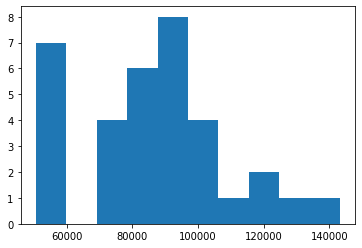

In [14]:
plt.hist(train.groupby(by=['date_block_num'])['item_cnt_day'].count())

The item count has quite a few outliers. The amount of rows for each month is also vastly different. Both of these findings can influence training.

## Test

In [15]:
print('Size of test-set:', len(test))
test.head()

Size of test-set: 214200


,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


as we can see test does not have many features. We will have to create those.

In [16]:
train['shop_id'].nunique() - test['shop_id'].nunique(), \
train['item_id'].nunique() - test['item_id'].nunique(), \
len(list(set(test['item_id']) - set(train['item_id']))), \
len(list(set(test['shop_id']) - set(train['shop_id'])))

(18, 16707, 363, 0)

We can see that some shops and many items do not appear in the test set but do in the train set. These will not be necessary for training.

Also 363 items that appear in the test set never appear in the train set. Since training on the test dataframe will almost never give output as 0, we should make sure the distribution between train and test is similar to improve training performance. We can do this by adding rows with 0 sales as values.

# Data Leakages
During EDA we discovered that many items and shops are not being asked for in the test set. We remove these from the train set.

In [17]:
before_size = len(train)
train = train[train['shop_id'].isin(test['shop_id'].unique())]
train = train[train['item_id'].isin(test['item_id'].unique())]
after_size = len(train)
print(f'before size: {before_size}', '\n', f'after size: {after_size}')

before size: 2935843 
 after size: 1224434


# Data Preprocessing and Generation
We are dealing with a 1 month future prediction problem. If we teach the model to predict sales 1 month into the future, then we can use all features provided in the training set instead of being limited to the test sets features.

In [18]:
train_data = train.drop(columns=['date']) \
.groupby(by=['date_block_num', 'shop_id', 'item_id'], as_index=False) \
.agg({'item_price':['sum', 'mean'], 'item_cnt_day':['sum']})

## Add Missing Combinations
We add the missing product shop month combos to make the distribution train/test similar

In [19]:
# Build empty DataFrame
shop_ids = train_data['shop_id'].unique()
item_ids = train_data['item_id'].unique()  

# Extend later with item ids in test
# item_ids = np.concatenate([item_ids, np.array(list(set(test['item_id']) - set(train['item_id'])))])
# item_ids.sort()

empty_df = []
for month_block in range(34):
    for shop_id in shop_ids:
        for item_id in item_ids:
            empty_df.append([month_block, shop_id, item_id])

empty_df = pd.DataFrame(empty_df, columns=['date_block_num', 'shop_id', 'item_id'])

In [20]:
# Merge train_data into empty_df and fill NaNs with 0
train_data = pd.merge(empty_df, train_data, on=['date_block_num', 'shop_id', 'item_id'], how='left').fillna(0)

## Clean Data

In [21]:
# Remove price outliers
train_data = train_data[train_data['item_price'] >= 0]
train_data = train_data[train_data['item_price'] < 100000]

In [22]:
# Remove count outliers
train_data = train_data[train_data['item_cnt_day'] >= 0]
train_data = train_data[train_data['item_cnt_day'] <= 20]

# Or Clip them
# train_data['item_cnt_day'] = train_data['item_cnt_day'].clip(0, 20)

## Basic Features

### Date Block Num

In [23]:
test_data['date_block_num'] = 34

### Month

In [24]:
train_data['month'] = train_data['date_block_num'] % 12
test_data['month'] = test_data['date_block_num'] % 12

### Year

In [34]:
train_data['year'] = train_data['date_block_num'] // 12 + 2013
test_data['year'] = test_data['date_block_num'] // 12 + 2013

### Days in Month

In [26]:
days_in_month = pd.Series([31,28,31,30,31,30,31,31,30,31,30,31])
train_data['days_in_month'] = train_data['month'].map(days_in_month).astype(np.int8)
test_data['days_in_month'] = test_data['month'].map(days_in_month).astype(np.int8)

### Item Category

In [27]:
item_category_map = items[['item_id', 'item_category_id']]
train_data = pd.merge(train_data, item_category_map, on=['item_id'])
test_data = pd.merge(test_data, item_category_map, on=['item_id'])

## Downcast types

In [35]:
train_data['date_block_num'] = train_data['date_block_num'].astype(np.int8)
train_data['shop_id'] = train_data['shop_id'].astype(np.int16)
train_data['item_id'] = train_data['item_id'].astype(np.int16)
train_data['item_price'] = train_data['item_price'].astype(np.float32)
train_data['item_cnt_day'] = train_data['item_cnt_day'].astype(np.int16)
train_data['month'] = train_data['month'].astype(np.int8)
train_data['year'] = train_data['year'].astype(np.int16)
train_data['item_category_id'] = train_data['item_category_id'].astype(np.int16)

## Lag Based Features

In [29]:
lags = [1, 2, 3, 6, 12]

def add_lag_features(train_data, test_data, grouped_data, lags, old_name, new_name, merge_list):
    for lag in lags:
        lag_series = grouped_data.copy()
        composed_name = f'{new_name}_lag{lag}m'
        lag_series['date_block_num'] += lag
        lag_series.rename(columns={old_name: composed_name}, inplace=True)
        train_data = pd.merge(train_data, lag_series, on=merge_list, how='left').fillna(0)
        test_data = pd.merge(test_data, lag_series, on=merge_list, how='left').fillna(0)
        
        train_data[composed_name] = train_data[composed_name].astype(train_data[old_name].dtype)
        test_data[composed_name] = test_data[composed_name].astype(train_data[old_name].dtype)
        
    return train_data, test_data

In [30]:
# Month Shop Item Sales
month_shop_item = train_data[['date_block_num', 'shop_id', 'item_id', 'item_cnt_day']]
train_data, test_data = add_lag_features(train_data, test_data, month_shop_item, lags, 'item_cnt_day', 'month_shop_item_sales', ['date_block_num', 'shop_id', 'item_id'])

# Month Shop Sales
month_shop = train_data.groupby(['date_block_num', 'shop_id'], as_index=False)['item_cnt_day'].sum()
train_data, test_data = add_lag_features(train_data, test_data, month_shop, lags, 'item_cnt_day', 'month_shop_sales', ['date_block_num', 'shop_id'])

# Month Item Sales
month_item = train_data.groupby(['date_block_num', 'item_id'], as_index=False)['item_cnt_day'].sum()
train_data, test_data = add_lag_features(train_data, test_data, month_item, lags, 'item_cnt_day', 'month_item_sales', ['date_block_num', 'item_id'])

Remove the first max(lag) months of train dataset as these have no lag values.

In [31]:
train_data = train_data[train_data['date_block_num'] >= max(lags)]

## Result

In [36]:
train_data

,date_block_num,shop_id,item_id,item_price,item_cnt_day,month,year,days_in_month,item_category_id,month_shop_item_sales_lag1m,...,month_shop_sales_lag1m,month_shop_sales_lag2m,month_shop_sales_lag3m,month_shop_sales_lag6m,month_shop_sales_lag12m,month_item_sales_lag1m,month_item_sales_lag2m,month_item_sales_lag3m,month_item_sales_lag6m,month_item_sales_lag12m
504,12,2,33,199.0,1,0,2014,31,37,1,...,555,299,201,242,248,38,12,30,38,42
505,12,3,33,199.0,2,0,2014,31,37,1,...,462,375,279,204,187,38,12,30,38,42
506,12,4,33,0.0,0,0,2014,31,37,0,...,857,477,472,371,434,38,12,30,38,42
507,12,6,33,199.0,3,0,2014,31,37,1,...,1683,1015,925,680,704,38,12,30,38,42
508,12,7,33,199.0,1,0,2014,31,37,1,...,1181,788,646,523,534,38,12,30,38,42
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6728113,33,49,15925,0.0,0,9,2015,31,72,0,...,542,885,743,416,400,0,0,0,0,0
6728114,33,39,15925,0.0,0,9,2015,31,72,0,...,652,711,488,468,393,0,0,0,0,0
6728115,33,48,15925,0.0,0,9,2015,31,72,0,...,1020,1251,973,783,849,0,0,0,0,0
6728116,33,34,15925,0.0,0,9,2015,31,72,0,...,369,421,360,295,219,0,0,0,0,0


In [37]:
test_data

,ID,shop_id,item_id,date_block_num,month,year,days_in_month,item_category_id,month_shop_item_sales_lag1m,month_shop_item_sales_lag2m,...,month_shop_sales_lag1m,month_shop_sales_lag2m,month_shop_sales_lag3m,month_shop_sales_lag6m,month_shop_sales_lag12m,month_item_sales_lag1m,month_item_sales_lag2m,month_item_sales_lag3m,month_item_sales_lag6m,month_item_sales_lag12m
0,0,5,5037,34,10,2015,30,19,0,1,...,989,956,1156,773,777,25,88,117,82,53
1,5100,4,5037,34,10,2015,30,19,0,0,...,688,640,790,601,786,25,88,117,82,53
2,10200,6,5037,34,10,2015,30,19,1,0,...,1528,1304,1355,1084,1522,25,88,117,82,53
3,15300,3,5037,34,10,2015,30,19,0,0,...,606,561,587,565,679,25,88,117,82,53
4,20400,2,5037,34,10,2015,30,19,0,1,...,665,726,877,545,585,25,88,117,82,53
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214195,193799,46,969,34,10,2015,30,37,0,0,...,1158,1067,1421,1067,1260,3,5,1,2,6
214196,198899,41,969,34,10,2015,30,37,0,0,...,702,589,814,646,744,3,5,1,2,6
214197,203999,44,969,34,10,2015,30,37,1,0,...,755,724,703,596,691,3,5,1,2,6
214198,209099,39,969,34,10,2015,30,37,0,0,...,707,652,711,518,539,3,5,1,2,6


# Validation
The Train/Test split is a time based split. The test data is the month (date_block_num 34) directly after the data in the train data (date_block_num 12 - 33). Hence for training we will use a time based split as well by using block 12 - 32 as training and using 33 as validation.

After submitting the csv a few times and observing the loss for the public and private leaderboard to be almost identical we take these are both randomly sampled from the test set.

### Train Validation Split

In [32]:
X = train_data.drop(columns=['item_cnt_day', 'item_price'])
y = train_data['item_cnt_day']

#del train_data
#gc.collect()

In [33]:
X_train = X[X['date_block_num'] < 33]
y_train = y[X['date_block_num'] < 33]
X_val = X[X['date_block_num'] == 33]
y_val = y[X['date_block_num'] == 33]

# Training

In [34]:
lr = LinearRegression()
lr.fit(X_train, y_train)
pred_lr = lr.predict(X_val.values)

print('Validation R-squared for linreg is %f' % r2_score(y_val, pred_lr))

Validation R-squared for linreg is 0.270714


### Random Forest
We use Random forest to plot accuracy against amount of trees to get an idea how good our features work with tree besed classifiers.

In [46]:
rf = RandomForestClassifier(n_estimators=100, max_depth=7, n_jobs=-1)
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=7, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [ ]:
predictions = []
r2s = []
accuracys = []

for tree in rf.estimators_:
    predictions.append(tree.predict_proba(X_val.fillna(0))[None, :])
    
predictions = np.vstack(predictions)

In [44]:
# Compute cumulative average over predictions
cum_mean = np.cumsum(predictions, axis=0)/np.arange(1, predictions.shape[0] + 1)[:, None, None]

# Compute score for each n_estimator value
for pred in cum_mean:
    r2s.append(r2_score(y_val, np.argmax(pred, axis=1)))
    accuracys.append(accuracy_score(y_val, np.argmax(pred, axis=1)))

4688

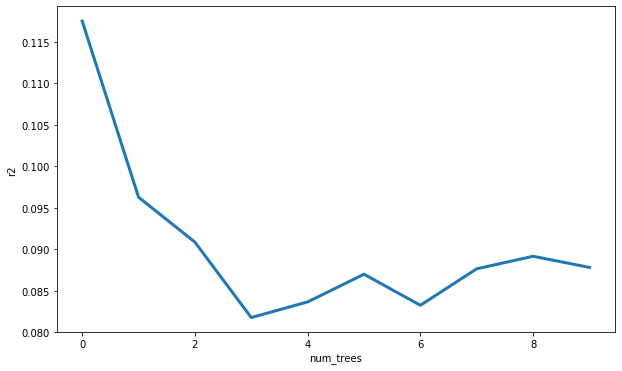

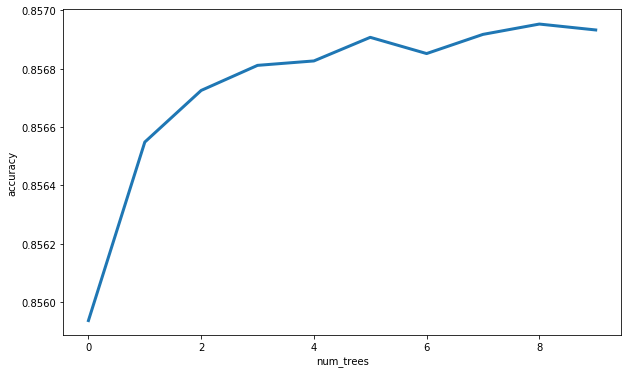

In [45]:
plt.figure(figsize=(10, 6))
plt.plot(r2s, linewidth=3)
plt.xlabel('num_trees')
plt.ylabel('r2')

plt.figure(figsize=(10, 6))
plt.plot(accuracys, linewidth=3)
plt.xlabel('num_trees')
plt.ylabel('accuracy')
plt.plot()

del rf
del predictions
del r2s
del accuracys
gc.collect()